# Workshop VTK Amsterdam - Leadtime analysis
Summary: Analysing Amsterdam rates dataset for the VTK Workshop

## Problem statement


Given: a rates table for Amsterdam with rates on all available rooms for a set of fixed dimensions (see repository readme).

Tasks summary:
 * Define a query to transform this rates table to an availability table with the count of available rooms per (extract_date_local, from_data_local).   
 * Export the availability table to a .csv and save to your machine
 * Analyze the availability table and find the largest drops in availability at unusual lead_times (drops in availability at lead_times shorter than 10 days are normal; hotels gradually drop the prices for rooms which aren't getting sold when they near the arrival date)
 * Can you explain why the availability for these from_dates started to drop at those specific extract_dates?

## Solution

The solution will be done using Pandas. This is available to use in the notebook environment on Google Colab. You'll need to install it locally using pip (see the `data/requirements.txt` file in the repository).

### Transform & Export from BigQuery.

Write a query which transforms the rates table so you get a table with for each arrival date and extract date combo, the number of available rooms. Let's call this transformed data the `availability data`.

Export the resulting table: download it as a csv file and make sure it is available for the notebook. You can upload it on Colab.



``` mysql 
SELECT from_date_local, extract_date_local, count(*) as count_available_rooms
FROM `oi-hackaton-vtk2019.workshop.hackathon_vtk_amsterdam_rates` 
GROUP BY from_date_local, extract_date_local 
````

### Analysis using Pandas.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

### Read the csv using Pandas. Print the first few rows of the dataset for inspection.

In [0]:
df_availability = pd.read_csv("availability.csv")
df_availability["from_date_local"] = pd.to_datetime(df_availability.from_date_local, format='%Y-%m-%d')
df_availability["extract_date_local"] = pd.to_datetime(df_availability.extract_date_local, format='%Y-%m-%d')

In [13]:
df_availability.head()

,from_date_local,extract_date_local,count_available_rooms
0,2019-05-22,2019-04-30,641
1,2019-05-12,2019-04-30,657
2,2019-05-30,2019-04-29,569
3,2019-05-28,2019-04-29,711
4,2019-05-04,2019-04-29,410


### How many rows (so from_date_local, extract_date_local pairs) does the dataset contain?

In [14]:
df_availability.shape

(5944, 3)

In [0]:
# Make a folder to save plots we generate
figures_folder = "figures"
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

### Make a plot of the dataset.

We need for each from_date_local the evolution in the available rooms over the course of all the extract_date_local (all meaning all the extract dates for a particular from_date).

Each line on your graph is a certain from date, and in general you'll see the availability gradually dropping for each from_date when the extract_date is progressing. This is because rooms are being sold out when they are coming closer to the arrival date. At the end of each line you can see an increase, as there are some last-minute rooms being put on the market in an effort to sell them.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 737091.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


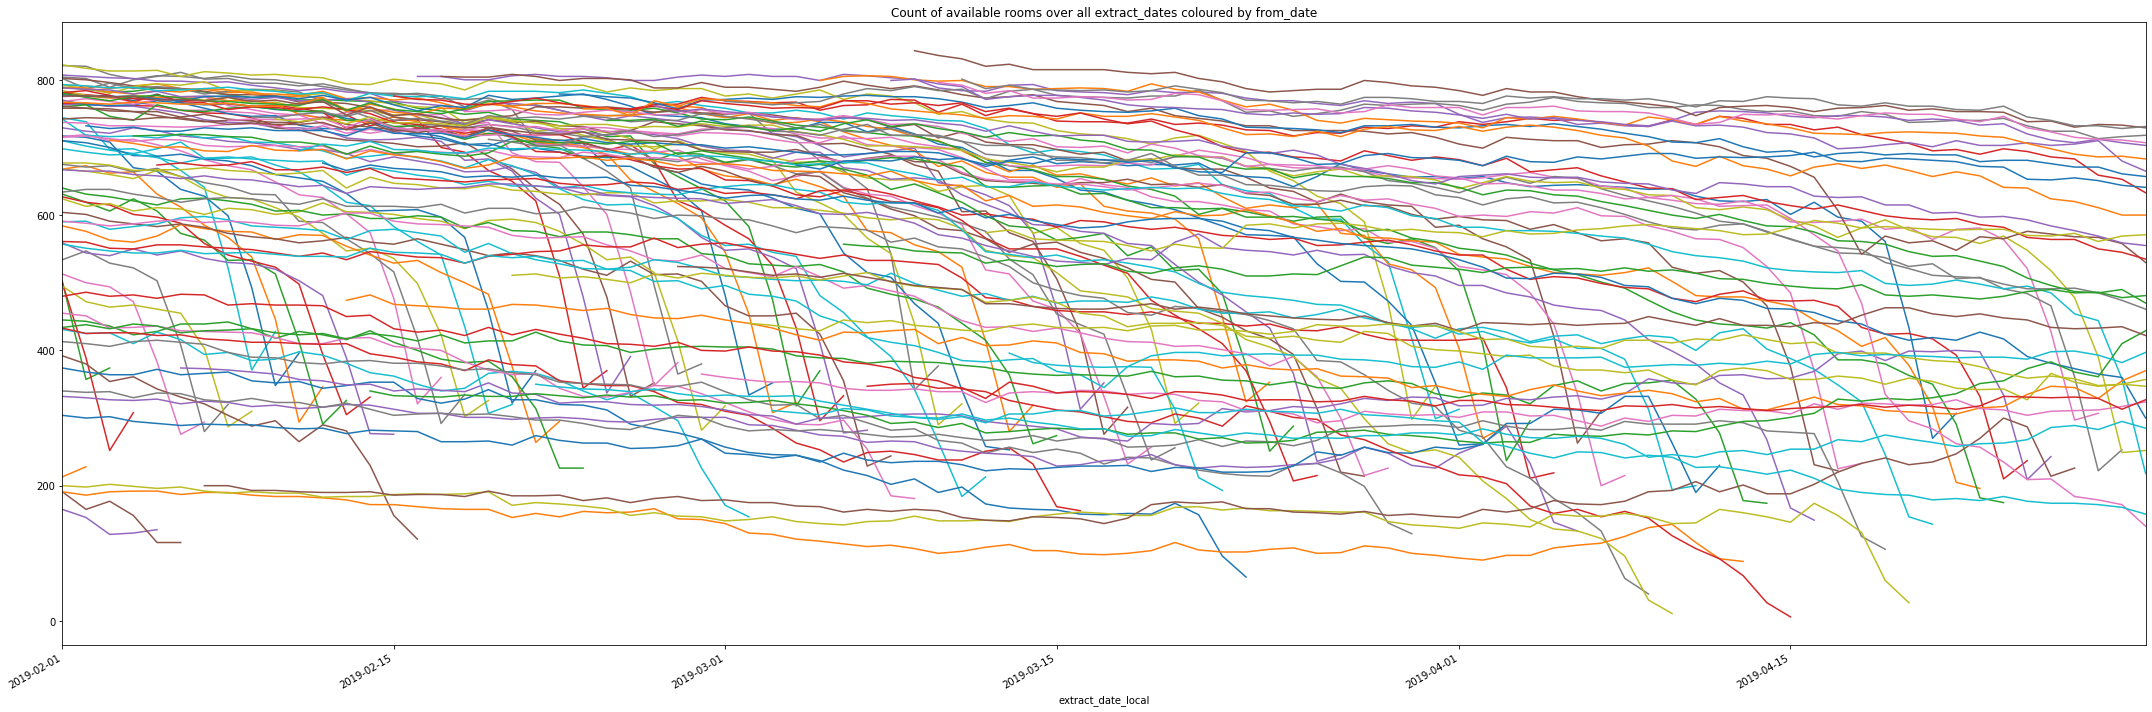

In [16]:
plt.figure(figsize=(30, 10))
df_availability.groupby("from_date_local").apply(lambda x: x.set_index("extract_date_local")["count_available_rooms"].plot())
plt.title("Availability change ")
plt.title("Count of available rooms over all extract_dates coloured by from_date")
plt.tight_layout()
plt.savefig("figures/count_all_lead_times.png")

The resulting graph should look like the image included in the repository readme. 

### Now filter out the data point from lead times less then 10 days, so when the difference between the arrival date and the from date is less than 10 days. These availability drops are normal and of no interest to us.

In [0]:
# filter on lead_times <-10
df_availability["lead_times"] = (df_availability.extract_date_local - df_availability.from_date_local).dt.days
df_availability = df_availability[df_availability.lead_times<-10]

Make the same plot again as in the previous step, which will be less crowded now.

In [0]:
plt.figure(figsize=(30, 10))
df_availability.groupby("from_date_local").apply(lambda x: x.set_index("extract_date_local")["count_available_rooms"].plot())
plt.title("Availability change ")
plt.title("Count of available rooms over all extract_dates coloured by from_date (filtered on lead_times < -10 ) ")
plt.tight_layout()
plt.savefig("figures/count_filtered_lead_times.png")

### Calculate for each of the remaining from_dates the difference between the maximum number of availability and the minimum which we observe in the dataset. Print the highest and lowest differences.

In [18]:
decreases_over_whole_period = (df_availability
                               .groupby("from_date_local")
                               .apply(lambda x:  x.loc[x['extract_date_local'].idxmax()].count_available_rooms - x.loc[x['extract_date_local'].idxmin()].count_available_rooms) )

decreases_over_whole_period.sort_values()

from_date_local
2019-05-08   -569
2019-04-10   -428
2019-04-15   -310
2019-04-09   -293
2019-04-24   -280
             ... 
2019-05-30     -3
2019-02-12      0
2019-05-31      1
2019-04-27      2
2019-05-04     11
Length: 109, dtype: int64

### Plot these differences per from_date. You'll see some peaks in the graph. These peaks indicate from_dates where there is a large difference in availability, possibly due to an unusual drop in availability over the course of a few days.

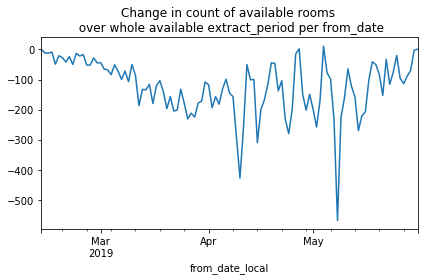

In [19]:
decreases_over_whole_period.plot()
plt.title("Change in count of available rooms \n over whole available extract_period per from_date")
plt.tight_layout()
plt.savefig("figures/availability_change_over_whole_period.png")

### Another approach: look at the difference in availability for a from_date over a period of a (window of a) few extract_days and look for large differences. A large difference indicates a steep drop in availability over a certain window of days.

In [20]:
df_availability.head()

,from_date_local,extract_date_local,count_available_rooms,lead_times
0,2019-05-22,2019-04-30,641,-22
1,2019-05-12,2019-04-30,657,-12
2,2019-05-30,2019-04-29,569,-31
3,2019-05-28,2019-04-29,711,-29
8,2019-05-19,2019-04-30,718,-19


In [21]:
window = 5
df_result = (df_availability
            .groupby("from_date_local")
            .apply(lambda x: (x.count_available_rooms - x.count_available_rooms.shift(window)).min() )
            )
                                
df_result.sort_values()

from_date_local
2019-05-08   -299.0
2019-05-07   -146.0
2019-04-10   -143.0
2019-04-09   -103.0
2019-04-11    -80.0
              ...  
2019-02-12      NaN
2019-02-13      NaN
2019-02-14      NaN
2019-02-15      NaN
2019-02-16      NaN
Length: 109, dtype: float64

### Plot this, it should look very similar to the previous plot, with peaks at the same dates

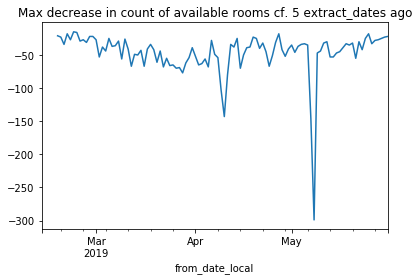

In [22]:
df_result.plot()
plt.title("Max decrease in count of available rooms cf. 5 extract_dates ago")
plt.tight_layout()
plt.savefig("figures/availability_change_over_5_days.png")

#### When looking at the max difference in availability compared to 5 days ago, two from_dates are huge outliers. Which are these? Plot the evolution of their availability. You'll see that one of them has a steep dive in availability over the course of a few days, and the other one has a significantly steeper decline in availability compared to previously starting at a certain extrac_date.

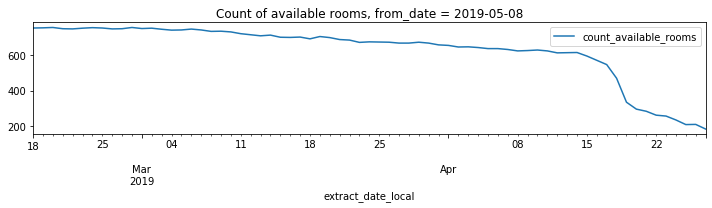

In [23]:
fig, ax = plt.subplots(1,1,figsize = (10,3))
df_availability[df_availability.from_date_local == pd.datetime(2019, 5, 8)].plot("extract_date_local", "count_available_rooms", ax = ax)
plt.title("Count of available rooms, from_date = 2019-05-08")
plt.tight_layout()
plt.savefig("figures/tottenham.png")

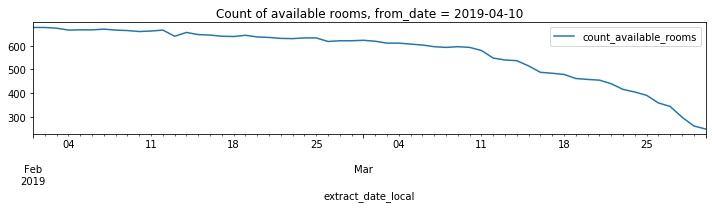

In [24]:
fig, ax = plt.subplots(1,1,figsize = (10,3))
df_availability[df_availability.from_date_local == pd.datetime(2019, 4, 10)].plot("extract_date_local", "count_available_rooms", ax = ax)
plt.title("Count of available rooms, from_date = 2019-04-10")
plt.tight_layout()
plt.savefig("figures/juventus.png")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 737091.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


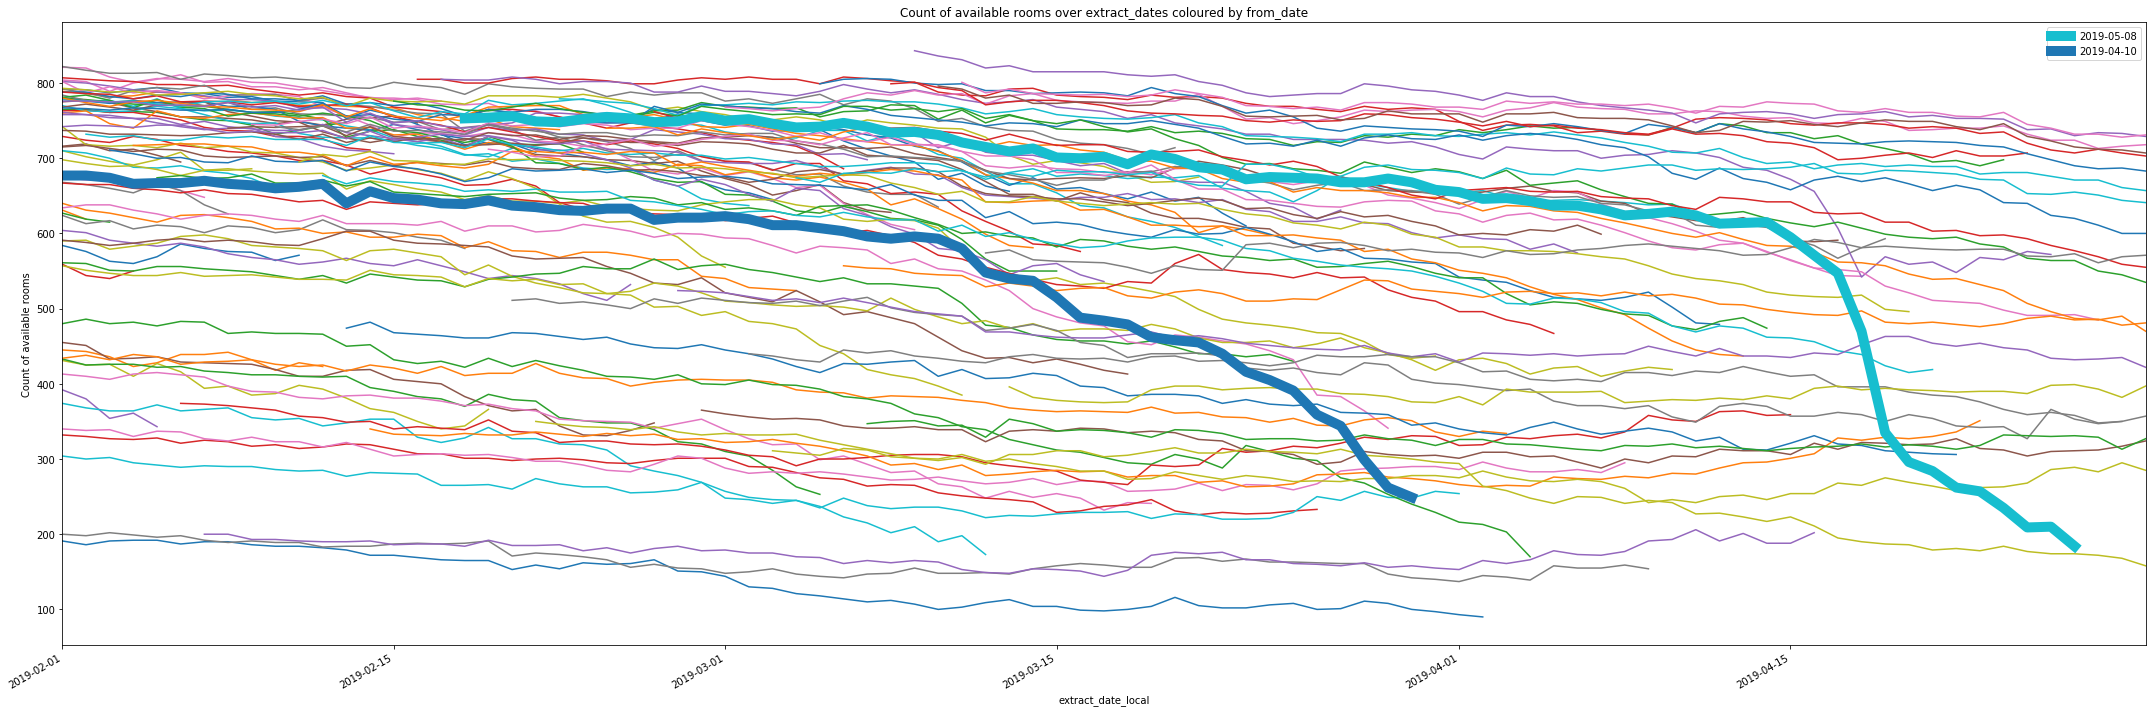

In [25]:
# Highlighted these 2 dates on the first graph
fig, ax = plt.subplots(figsize=(30, 10))
df_availability.groupby("from_date_local").apply(lambda x: x.set_index("extract_date_local")["count_available_rooms"].plot())
df_availability[df_availability.from_date_local == pd.datetime(2019, 5, 8)].plot("extract_date_local", "count_available_rooms", ax = ax, lw = 10, label = "2019-05-08")
df_availability[df_availability.from_date_local == pd.datetime(2019, 4, 10)].plot("extract_date_local", "count_available_rooms", ax = ax, lw = 10, label = "2019-04-10")

plt.ylabel("Count of available rooms")
plt.title("Count of available rooms over extract_dates coloured by from_date")
plt.tight_layout()
plt.savefig("figures/count_filtered_increases.png")

# Explanation

### For each of the 2 selected from_dates, look at their availability evolution. Query the events table you have in BigQuery to look for events which might be related to this behaviour.

### 10 April:

Text(0.5, 1.0, 'Count of available rooms, from_date = 2019-04-10')

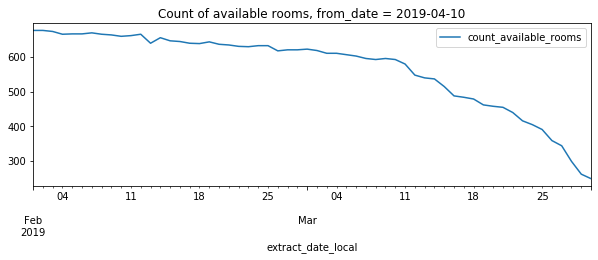

In [26]:
fig, ax = plt.subplots(1,1,figsize = (10,3))
df_availability[df_availability.from_date_local == pd.datetime(2019, 4, 10)].plot("extract_date_local", "count_available_rooms", ax = ax)
plt.title("Count of available rooms, from_date = 2019-04-10")

#### Quering events on this from_date_local in bigquery:

``` mysql 
SELECT * FROM `oi-hackaton-vtk2019.workshop.hackathon_vtk_amsterdam_events` 
WHERE Day_of_Start_Date = DATE '2019-04-10'
```

#### Returns the next table: 

In [0]:
df_events = pd.read_csv("events_2019-04-10.csv")
df_events["Day_of_Start_Date"] = pd.to_datetime(df_events["Day_of_Start_Date"], format = "%Y-%m-%d")
df_events["Day_of_End_Date"] = pd.to_datetime(df_events["Day_of_End_Date"], format = "%Y-%m-%d")

In [28]:
df_events.columns

Index(['Name', 'Day_of_Start_Date', 'Day_of_End_Date', 'Importance_Level'], dtype='object')

In [30]:
df_events[df_events["Day_of_Start_Date"] == pd.datetime(2019, 4, 10)]

,Name,Day_of_Start_Date,Day_of_End_Date,Importance_Level
0,Mobile and App Marketing Amsterdam Summit,2019-04-10,2019-04-10,Low Importance
1,Robyn,2019-04-10,2019-04-10,Low Importance
2,Drug - Device Combination Products Summit,2019-04-10,2019-04-11,Low Importance
3,Life Insurance Forum,2019-04-10,2019-04-11,Low Importance
4,Process Excellence & Business Transformation C...,2019-04-10,2019-04-11,Low Importance
5,VRX Conference & Expo,2019-04-10,2019-04-11,Low Importance
6,Annual World Retail Forum,2019-04-10,2019-04-12,Low Importance
7,GEO Conference,2019-04-10,2019-04-12,Low Importance
8,React Amsterdam Conference,2019-04-10,2019-04-12,Low Importance
9,The Global Engineering Procurement & Construct...,2019-04-10,2019-04-12,Low Importance


#### Explanation
12 March: Juventus qualified to play the quarter-finals against Ajax. 
The quarter-final match in Amsterdam was on 10 April.


### 8 May:

Text(0.5, 1.0, 'Count of available rooms, from_date = 2019-05-08')

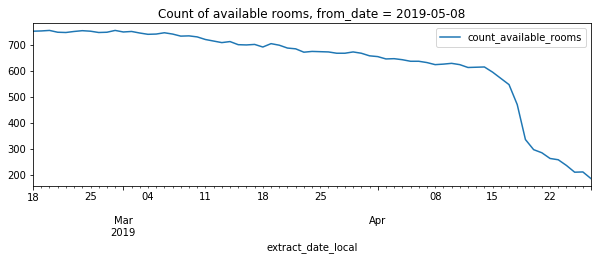

In [31]:
fig, ax = plt.subplots(1,1,figsize = (10,3))
df_availability[df_availability.from_date_local == pd.datetime(2019, 5, 8)].plot("extract_date_local", "count_available_rooms", ax = ax)
plt.title("Count of available rooms, from_date = 2019-05-08")

#### Querying events on this day in bigquery:

``` mysql 
SELECT * FROM `oi-hackaton-vtk2019.workshop.hackathon_vtk_amsterdam_events` 
WHERE Day_of_Start_Date = DATE '2019-05-08'
```

#### Returns the next table: 

In [0]:
df_events = pd.read_csv("events_2019-05-08.csv")
df_events["Day_of_Start_Date"] = pd.to_datetime(df_events["Day_of_Start_Date"], format = "%Y-%m-%d")
df_events["Day_of_End_Date"] = pd.to_datetime(df_events["Day_of_End_Date"], format = "%Y-%m-%d")

In [34]:
df_events[df_events["Day_of_Start_Date"] == pd.datetime(2019, 5, 8)]

,Name,Day_of_Start_Date,Day_of_End_Date,Importance_Level
0,Cdisc Europe Interchange,2019-05-08,2019-05-09,Low Importance
1,Savant Supply Chain Congress,2019-05-08,2019-05-09,Low Importance
2,"Sulphur Cap 2020 Conference, Awards and Exhibi...",2019-05-08,2019-05-09,Low Importance
3,Independent Hotel Show,2019-05-08,2019-05-09,High Importance
4,Ajax vs. Tottenham,2019-05-08,2019-05-08,Medium Importance


#### Explanation
17 April: Tottenham qualified to play the semi-finals against Ajax. 
The semi-final match in Amsterdam was on 8 May
